In [75]:
from ase import io as aio
from ase import build
import numpy as np
import abtem
import matplotlib.pyplot as plt
import ase.visualize.plot as viz
from sim_stem import simulate_stem, preview_stem_result
from utils import tk_popover

In [0]:
abtem.config.set({"device":              "cpu",  # Configure abTEM to run on the GPU
                  "dask.lazy":           True,  # Setting to False can be useful for debugging
                  "dask.chunk-size":     "128 MB",  # 128 MB is the standard L3 cache size (per core)
                  "dask.chunk-size-gpu": "512 MB",  # Remember to leave space for overhead
                  "scheduler":           "threads",  # Threads or processes
                  "num_workers":         48  # Number of threads/processes to use for simulation (set to 1 for gpu)
                  })

<Axes: >

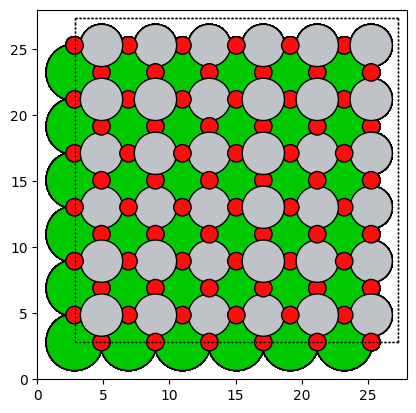

In [10]:
%matplotlib inline
uc = aio.read(tk_popover())

thickness: float = 200  # Angstrom
reps: int = 6

c = np.linalg.norm(build.surface(uc, indices=(1, 0, 0), layers=1, periodic=True).cell[2])
surf = build.surface(uc, indices=(1, 0, 0), layers=int(thickness//c + 1), periodic=True)
slab = abtem.orthogonalize_cell(surf)
slab *= (reps, reps, 1)
viz.plot_atoms(slab)

In [87]:
sigs = {"Ba": 0.0757,
        "Ti": 0.0893,
        "O":  0.0810}

fps = abtem.FrozenPhonons(slab,
                          num_configs=50,
                          sigmas=sigs,
                          ensemble_mean=False)  # Don't compute the mean, we want to see all of the configs

potential = abtem.Potential(fps,
                            sampling=0.04,
                            projection="infinite",
                            parametrization="kirkland",
                            slice_thickness=2)
detector = abtem.detectors.AnnularDetector(70, 200)

[########################################] | 100% Completed | 104.00 ms


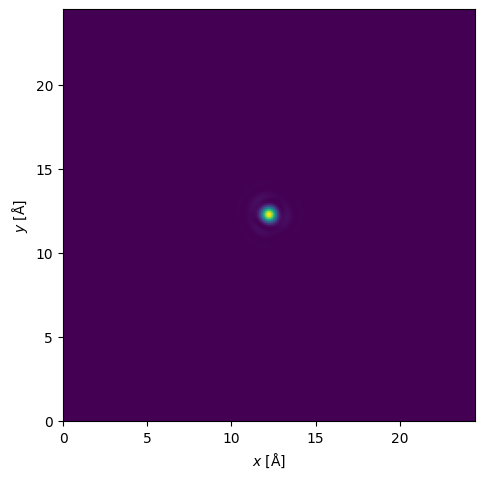

In [88]:
aberrations = {"C10":   22,     # Defocus (C1)
               "C12":   7,      # 2-fold stig (A1)
               "phi12": 2.71,   # 2-fold stig angle
               "C21":   335,    # Coma (B2)
               "phi21": 2.67,   # Coma angle
               "C23":   480,    # 3-fold stig (A2)
               "phi23": 0,      # 3-fold stig angle
               "C30":   -5200,  # Spherical aber (C3 / CS)
               "C32":   7600,   # "Star" aber (S3)
               "phi32": -0.37,  # Star aber angle
               "C34":   3900,   # 4-fold stig (A3)
               "phi34": -1.71,  # 4-fold stig angle
               "C41":   8.4e4,  # 4th order coma (B4)
               "phi41": -0.24,  # 4th order coma angle
               "C43":   1.4e5,  # Three-lobe aber (D4)
               "phi43": 1.40,   # Three-lobe aber angle
               "C45":   1.1e4,  # 5-fold stig (A4)
               "phi45": 1.40,   # 5-fold stig angle
               "C50":   -8e6,   # 5th order spherical aber (C5)
               "C52":   9.7e5,  # 5th order star aber (S5)
               "phi52": 2.04,   # 5th order star aber angle
               "C54":   3.2e5,  # Rosette aber (R5)
               "phi54": -2.09,  # Rosette aber angle
               "C56":   2.8e6,  # 6-fold stig (A5)
               "phi56": 0.98    # 6-fold stig angle
               }

abtem.Probe(semiangle_cutoff=17.9, energy=200e3, aberrations=aberrations).match_grid(potential).show()

scangrid = abtem.scan.GridScan((0, 0), (1/6, 1/6), fractional=True, potential=potential)

Simulating...
[########################################] | 100% Completed | 24m 5sss


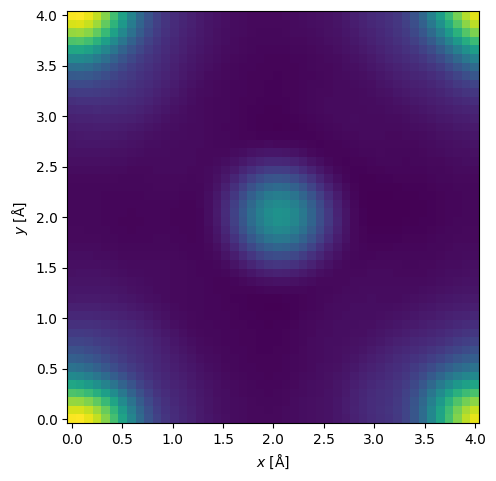

In [89]:
fpath = tk_popover(save=True)  # Setup filename before running the simulation, so we can save automatically
result = simulate_stem(potential=potential, detectors=detector, convergence=17.9, aberrations=aberrations, scan=scangrid, eager=True)
result.to_tiff(fpath)
preview_stem_result(result)

In [90]:
# 1. Find location of max, and its value
# 2. Get FWHM in x and y
# 3. Construct disk, and integrate it
# 4. Track value as we add more configs to the mean --> convergence

# By eye, slicing [2:-1, 2:-1] gets us just the central peak
# Before interpolating, central peak intensity is almost all in 3x3 region around peak
integrals = []
for res in result:
    max_loc = np.where(res.array==np.max(res.array[2:-1, 2:-1]))
    max_loc = (int(max_loc[0]), int(max_loc[1]))  # Return value of where is annoying to work with
    integrals.append(np.sum(res.array[max_loc[0]-1:max_loc[0]+1, max_loc[1]-1:max_loc[1]+1]))

means = []
for i, _ in enumerate(integrals):
    if i==0:
        means.append(integrals[i])
    else:
        means.append(sum(integrals[:i])/(i+1))

C:\Users\charles\AppData\Local\Temp\ipykernel_55464\2681321592.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_loc = (int(max_loc[0]), int(max_loc[1]))  # Return value of where is annoying to work with


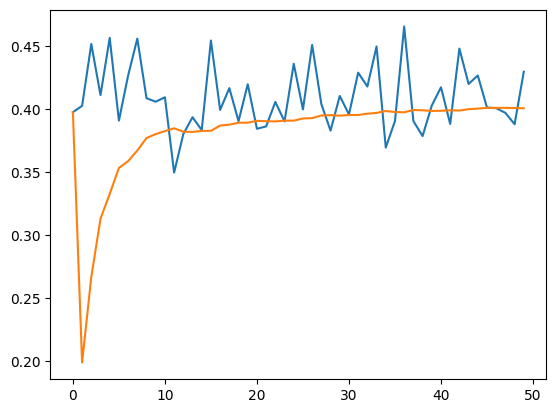

In [91]:
plt.plot(range(len(integrals)), integrals)
plt.plot(range(len(means)), means)
plt.show()

In [93]:
# And again, with Poisson noise
def add_poisson_noise(img: np.ndarray, px_size: float, dose: float) -> np.ndarray:
    valmin, valmax = np.min(img), np.max(img)
    normed = (img - valmin) / (valmax - valmin)
    e_per_px = dose * px_size**2
    return np.random.poisson(normed * e_per_px)

noisy = []
for res in result:
    noisy.append(add_poisson_noise(res.array, 0.162, 1e5))

In [97]:
integrals_noisy = []
for nres in noisy:
    max_loc = np.where(nres==np.max(nres[2:-1, 2:-1]))
    max_loc = (int(max_loc[0]), int(max_loc[1]))  # Return value of where is annoying to work with
    integrals_noisy.append(np.sum(nres[max_loc[0]-1:max_loc[0]+1, max_loc[1]-1:max_loc[1]+1]))

means_noisy = []
for i, _ in enumerate(integrals_noisy):
    if i==0:
        means_noisy.append(integrals_noisy[i])
    else:
        means_noisy.append(sum(integrals_noisy[:i])/(i+1))

C:\Users\charles\AppData\Local\Temp\ipykernel_55464\3799737075.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_loc = (int(max_loc[0]), int(max_loc[1]))  # Return value of where is annoying to work with


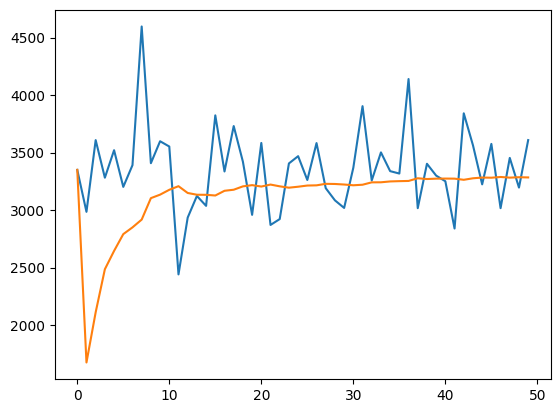

In [98]:
plt.plot(range(len(integrals_noisy)), integrals_noisy)
plt.plot(range(len(means_noisy)), means_noisy)
plt.show()